<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SBDN_GoogleNet_Exp1_CHUK_DUT_SZU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image
from tensorflow import keras
from keras.models import Sequential, Model,load_model
from keras import layers
from keras import regularizers
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Concatenate
from keras import regularizers

In [ ]:
!unzip -qq BlurDatasetImage.zip

In [ ]:
!unzip -qq BlurDatasetGT.zip

In [ ]:
from numpy import *
images_folder= "image/*"
labels_folder = "gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      # image resize
      image = Image.open(myFile)
      image = image.resize((224, 224))
      image = np.asarray(image)
      total_img.append(image)
      #Gt
      image_name=image_name[:-3]
      image_name=image_name+'png'
      label_image = Image.open(labels_folder+image_name)
      label_image = label_image.resize((224, 224))
      label_image = np.asarray(label_image)
      if (label_image.shape!=(224,224)):
        label_image=label_image[:,:,0]
      label.append (label_image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]]) 
  return label,total_img

In [ ]:
total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [ ]:
total_images.shape

In [ ]:
total_labels.shape

In [3]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [4]:
def ident_auxiliary(x,name=None):
  dec3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)#28*28*512
  dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
  dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
  dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
  dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",padding="same")(dec6)#224*224*1
  dec8 = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="relu",padding="same")(dec7)#224*224*1
  #FusionNetwork
  Upsam_Deep = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
  Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
  Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
  concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Deep,Upsam_Shallow1,Upsam_Shallow2,dec6])
  result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same")(concatted_Shallow) #224*224*1
  #Concatenate all results
  concatted_all = tf.keras.layers.Concatenate()([dec7,result_concatted_Shallow])
  Axilary_final_output= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid", padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005),name=name)(concatted_all) #224*224*1
  return Axilary_final_output

In [5]:
def identifier(x,name=None):
  dec2 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x) #14*14*512
  dec3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(dec2)#28*28*256
  dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
  dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
  dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
  dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",padding="same")(dec6)#224*224*1
  dec8 = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="relu",padding="same")(dec7)#224*224*1
  #FusionNetwork1
  Upsam_Deep1 = layers.Conv2DTranspose(128, (3, 3), strides=32, activation="relu", padding="same")(x)
  Upsam_Deep2 = layers.Conv2DTranspose(128, (3, 3), strides=16, activation="relu", padding="same")(dec2)
  Upsam_Deep3 = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
  concatted_deep = tf.keras.layers.Concatenate(axis=3)([Upsam_Deep1,Upsam_Deep2,Upsam_Deep3])
  result_concatted_deep= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same")(concatted_deep) #224*224*1
  #FusionNetwork2
  Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
  Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
  concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Shallow1,Upsam_Shallow2,dec6])
  result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same",)(concatted_Shallow) #224*224*1
  #Concatenate all results
  concatted_all = tf.keras.layers.Concatenate()([dec7,result_concatted_deep,result_concatted_Shallow])
  final_output= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid",name=name, padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005))(concatted_all) #224*224*1
  return final_output


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [9]:
def googlenet():
  layer_in = Input(shape=(224, 224, 3))  
  # stage-1
  layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  layer = BatchNormalization()(layer)
  # stage-2
  layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
  layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-3
  layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
  layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-4
  layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
  ident1  = ident_auxiliary(layer, name='ident1')
  #aux1  = auxiliary(layer, name='aux1')
  layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
  layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
  layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
  ident2 =ident_auxiliary(layer, name='ident2')
  #aux2  = auxiliary(layer, name='aux2')
  layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-5
  layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
  layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
  ident  = identifier(layer, name='ident')
  #layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
  # stage-6
  #layer = Flatten()(layer)
  #layer = Dropout(0.4)(layer)
  #layer = Dense(units=256, activation='linear')(layer)
  #main = Dense(units=1, activation='sigmoid', name='main')(layer)  
  model = Model(inputs=layer_in, outputs=[ident,ident1,ident2]) 
  return model

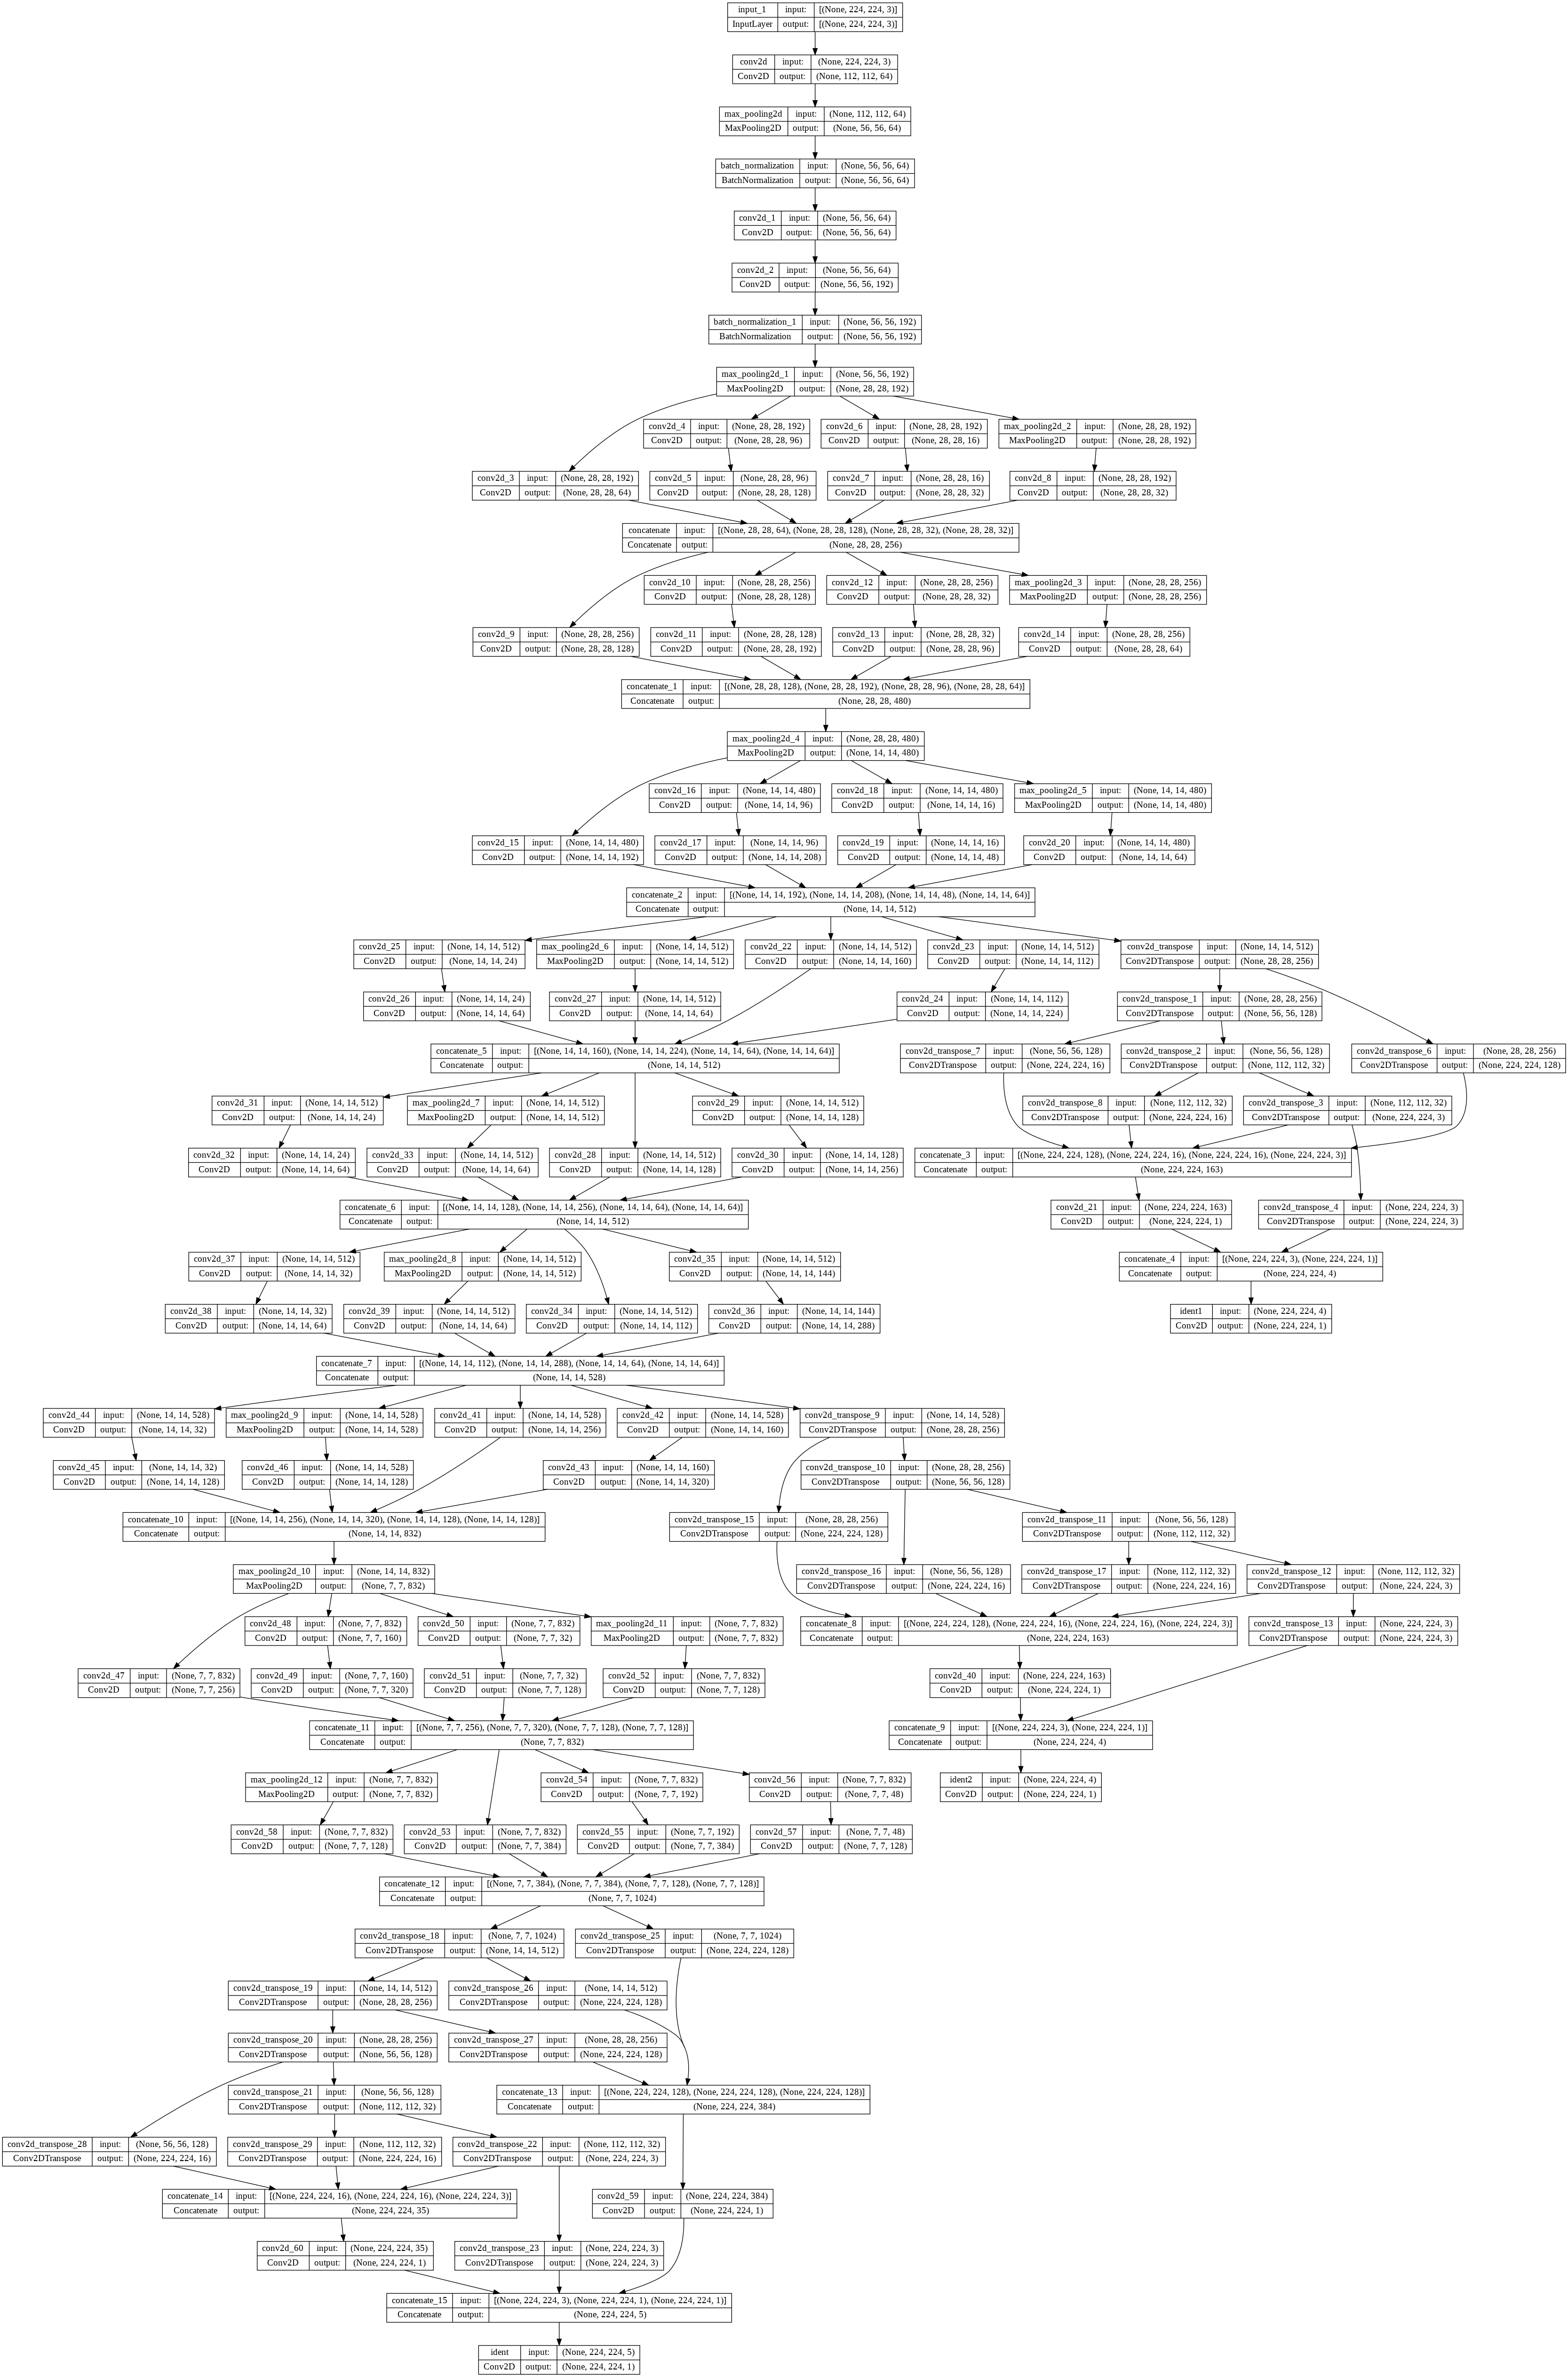

In [7]:
model = googlenet()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#model.summary()

In [ ]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy > self.point:
            self.model.stop_training = True
callbacks = [StopOnPoint(0.99)]

In [ ]:
x_train = total_images[:800].astype(np.float32)/ 255.0
y_train=total_labels[:800].astype(np.float32)/ 255.0
y_train=np.where(y_train>0.5,1.0,0.0)
y_train=(y_train)

In [ ]:
loss1="binary_crossentropy"
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss1,loss1],metrics=["accuracy"])

In [ ]:
history = model.fit(x_train,[y_train[1],y_train[1],y_train[1],y_train[0],y_train[0],y_train[0]], epochs=55,batch_size=20,validation_split=0.2,shuffle=True,callbacks=[callbacks])
model.save('sbdn_googlenet_exp1_chuk-dut_szu_model.h5')

In [ ]:
history_dict = history.history
print(history_dict.keys())

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'sbdn-googlenet_chuk-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","loss"])
plt.show()